In [5]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import warnings
import GF

warnings.filterwarnings("ignore")

In [6]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 30
npts_layer = 11

els_source = bemcs.initialize_els()
els_topo = bemcs.initialize_els()
els_b = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source) - in this case it is a semi-infinite strike-slip fault
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-0.5])
els_source.x2 = np.array([0])
els_source.y2 = np.array([-1e5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# topography
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)
# provide connectivity matrix
conmatrix = np.hstack(
    (
        np.arange(0, len(els_topo.x1) - 1).reshape(-1, 1),
        np.arange(1, len(els_topo.x1)).reshape(-1, 1),
    )
)
els_topo.conmatrix = conmatrix.astype(int)

In [7]:
# provide layered structure in terms of number of layers, location of layers (iterface with jump in μ), and μ values
nlayers = 5
zlayer = np.linspace(-5, 0, nlayers + 1)[0:-1]
mulayer = np.linspace(10, 1, nlayers + 1)
x1 = []
x2 = []
y1 = []
y2 = []

# calculation the dμ/dx and dμ/dy terms as α,β
conmatrix = np.zeros((nlayers * (npts_layer - 2), 2))
beta = np.zeros(nlayers * (npts_layer - 2))
for i in range(nlayers):
    xvals = np.linspace(-Lscale, Lscale, npts_layer)
    x1 = np.hstack([x1, xvals[0:-1]])
    x2 = np.hstack([x2, xvals[1:]])
    y1 = np.hstack([y1, np.ones(npts_layer - 1) * zlayer[i]])
    y2 = np.hstack([y2, np.ones(npts_layer - 1) * zlayer[i]])
    beta[i * (npts_layer - 2) : (npts_layer - 2) * (i + 1)] = (
        -(mulayer[i + 1] - mulayer[i]) / mulayer[i + 1]
    )
    conmatrix[i * (npts_layer - 2) : (npts_layer - 2) * (i + 1), :] = i * (
        npts_layer - 1
    ) + np.hstack(
        (
            np.arange(0, npts_layer - 2).reshape(-1, 1),
            np.arange(1, npts_layer - 1).reshape(-1, 1),
        )
    )

els_b.x1 = x1
els_b.x2 = x2
els_b.y1 = y1
els_b.y2 = y2
bemcs.standardize_els_geometry(els_b, reorder=False)
els_b.conmatrix = conmatrix.astype(int)

In [8]:
# combine topo and layered structure
els.x1 = np.hstack([els_topo.x1, els_b.x1])
els.x2 = np.hstack([els_topo.x2, els_b.x2])
els.y1 = np.hstack([els_topo.y1, els_b.y1])
els.y2 = np.hstack([els_topo.y2, els_b.y2])
bemcs.standardize_els_geometry(els, reorder=False)
els.conmatrix = np.concatenate(
    [els_topo.conmatrix, els_b.conmatrix + 1 + len(els_topo.conmatrix[:, 0])]
)
els.xc = els.x_centers[els.conmatrix[:, 0].astype(int)]
els.yc = els.y_centers[els.conmatrix[:, 0].astype(int)]

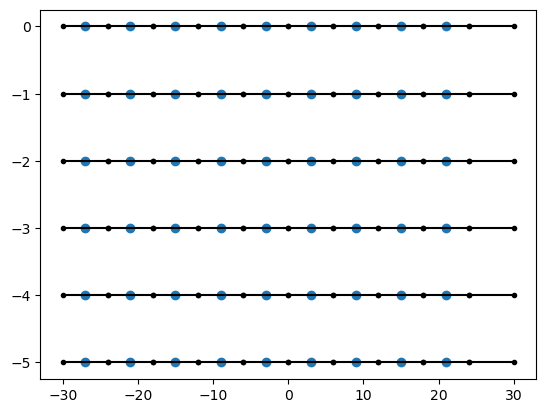

In [11]:
# plot evaluation points of new basis functions with mesh
plt.plot(els.xc, els.yc, "o")
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.show()